<a href="https://colab.research.google.com/github/JamesGrooms/drowsy_detection/blob/main/TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc


from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# New Section

In [ ]:
# assigning train and test directories
train_dir = "/content/drive/My Drive/Colab/train"
test_dir = "/content/drive/My Drive/Colab/test"

AttributeError: ignored

In [ ]:
# train and test sizes are the length of their respective directories
train_size = len("/content/drive/My Drive/Colab/train")
test_size = len("/content/drive/My Drive/Colab/test")

train_size, test_size

(35, 34)

In [ ]:
import cv2
import numpy as np
import pandas as pd
import shutil
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Flatten,Dropout,AvgPool2D
#from keras.layers.normalization import BatchNormalization
from keras.constraints import unit_norm

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size=224  #for the inception model
image_path= train_dir
BATCH_SIZE = 64

# Image augmentations
train_datagen=ImageDataGenerator(
                        rescale=1./255, # normalize pixel values between 0-1
                        validation_split=0.1,
                        horizontal_flip=True, # horizontal transposition
                        width_shift_range=0.2, # shift the weidth of the image 20%
                        height_shift_range=0.2, # shift the height of the image 20%
                        shear_range=0.2,
                        rotation_range=40, # random rotation at 40 degrees
                        fill_mode='nearest',
                        brightness_range=(0.1, 0.9),  # specify the range in which to decrease/increase brightness
                        zoom_range=(0.5, 1.5) # zooming in and out
)

train_generator=train_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='training',
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                         classes={'Open': 0, 
                               'no_yawn': 1,  
                                'Closed': 2,
                                  'yawn': 3}
                        )
                        

valid_datagen=ImageDataGenerator(
                        validation_split=0.1,
                        rescale=1./255
                        )

valid_generator=valid_datagen.flow_from_directory(
                        image_path, 
                        target_size=(image_size,image_size),
                        subset='validation',
                        shuffle=False,
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                        classes={'Open': 0,
                              'no_yawn': 1,  
                               'Closed': 2,
                                 'yawn': 3}
)

Found 2223 images belonging to 4 classes.
Found 244 images belonging to 4 classes.


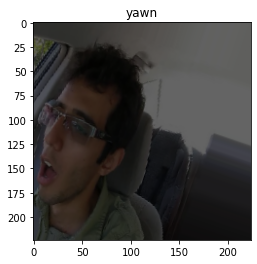

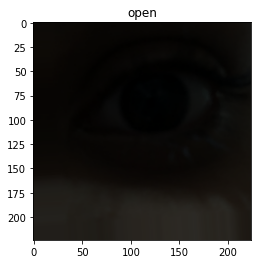

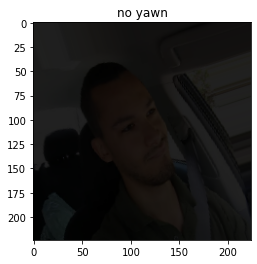

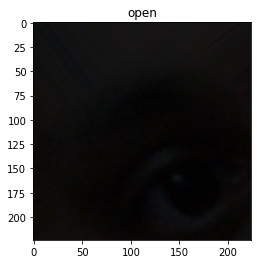

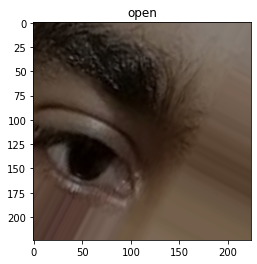

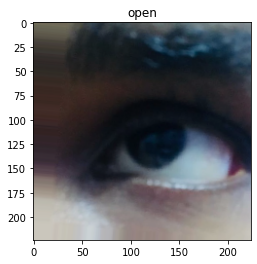

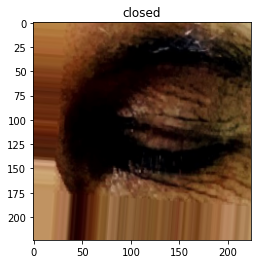

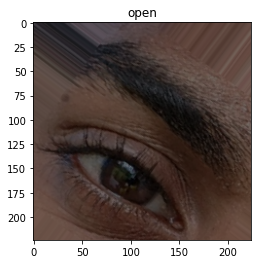

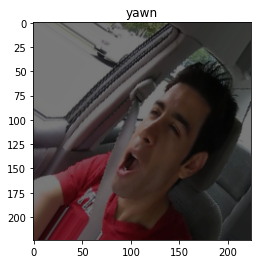

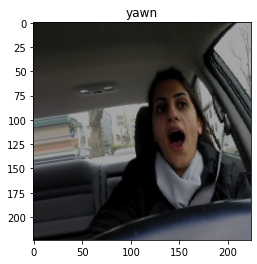

In [ ]:
x,y = train_generator.next()
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
for i in range(0,10):
    image = x[i]
    plt.imshow(image)
    c=0
    for i in y[i]:
        if i==0:
            c+=1
        else:break
    label=labels[c]
    label=label.replace('_',' ')
    label=label.lower()
    plt.title(label)
    plt.show()

In [ ]:
labels

{0: 'Open', 1: 'no_yawn', 2: 'Closed', 3: 'yawn'}

In [ ]:
from keras.applications.inception_v3 import InceptionV3

Inception = InceptionV3(input_shape = (224,224,3), 
                                include_top = False, 
                                weights = "imagenet")

#building a sequential model with inception layer base and only an average pooling layer before the output layer

model=Sequential()
model.add(Inception)

model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.layers[0].trainable=False

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 22,853,924
Trainable params: 1,051,140
Non-

In [ ]:
!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

In [ ]:
STEPS_PER_EPOCH = 2223 // BATCH_SIZE

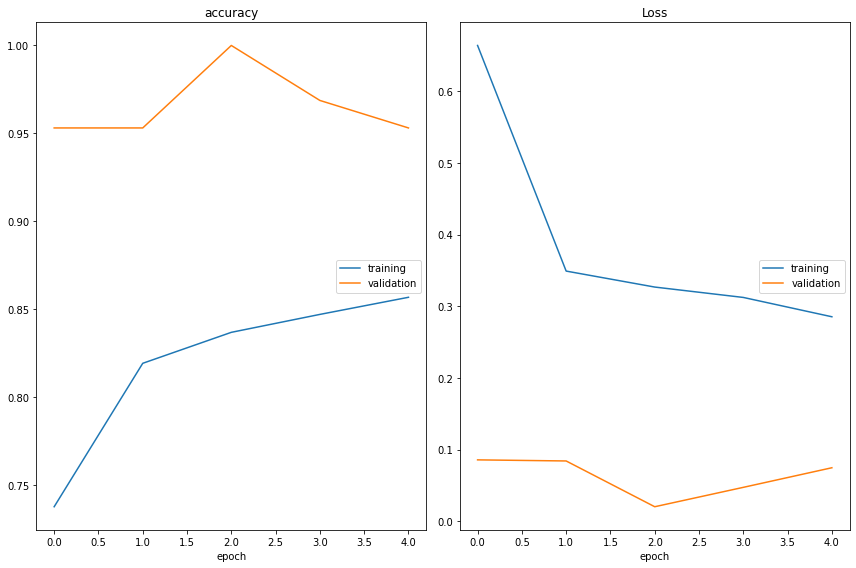

accuracy
	training         	 (min:    0.738, max:    0.857, cur:    0.857)
	validation       	 (min:    0.953, max:    1.000, cur:    0.953)
Loss
	training         	 (min:    0.285, max:    0.664, cur:    0.285)
	validation       	 (min:    0.020, max:    0.086, cur:    0.075)
34/34 [==============================] - 41s 1s/step - loss: 0.2853 - accuracy: 0.8569 - val_loss: 0.0747 - val_accuracy: 0.9531


In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5,min_delta=0,mode='auto',restore_best_weights=False,baseline=None)
checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min', period=1)
                             
history=model.fit_generator(train_generator,
                   steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=5,
                   validation_data=valid_generator,
                   validation_steps=1,
                   callbacks=[callback, plot_loss_1])

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/drive/My Drive/Colab/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/Colab/model_best_weights.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 22,853,924
Trainable params: 1,051,140
Non-trainable params: 21,802,784
____________________________________

In [ ]:
#predicting any random image
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  from IPython.display import Image
  display(Image(filename=path))
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0) /255
  classes = loaded_model.predict(x)
  print("Closed:", np.argmax(classes[0])==0, (classes[0][0]), round(classes[0][0]) * 100,"%") # 0 : Eyes closed
  print("Open:" , np.argmax(classes[0])==1, (classes[0][1]), round(classes[0][1]) * 100,"%") # 1 : Eyes open
  print("No-yawn:" , np.argmax(classes[0])==2, (classes[0][2]), round(classes[0][2])  * 100,"%")# 2 : No yawn
  print("Yawn:" , np.argmax(classes[0])==3, (classes[0][3]), round(classes[0][3])  * 100,"%")# 3 : Yawn
  print(f"Predicted label: {labels[np.argmax(classes[0])]}") # Predicted label
  print(f"Probability of prediction): {round(np.max(classes[0])) * 100} %") # Probablilty of prediction